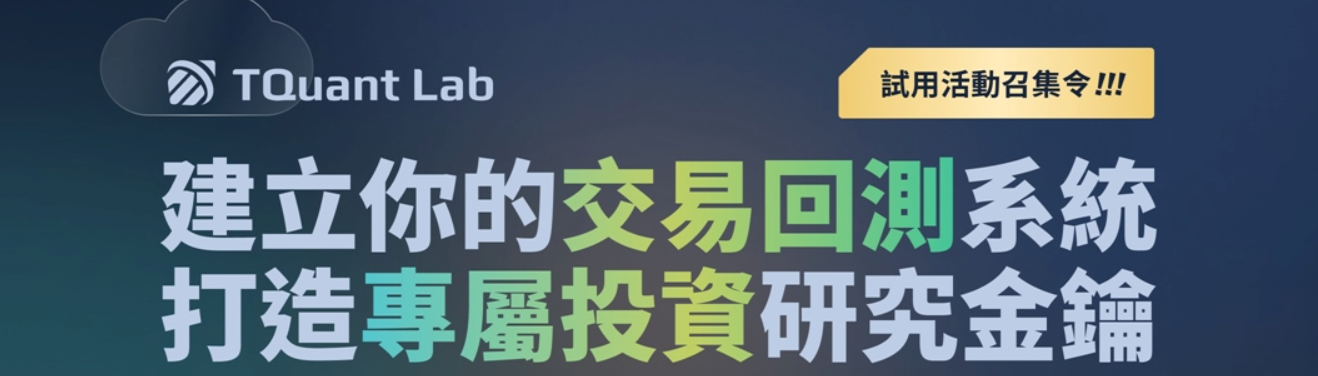

## 問題集:

1. 如何使用 TejToolAPI 自建因子。
2. 如何將因子導入 TQuant Lab 回測平台中。

In [2]:
import tejapi
import os
os.environ['TEJAPI_KEY'] = "your key" 
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from zipline.data import bundles
from zipline.pipeline import Pipeline
from zipline.pipeline.data import Column, DataSet,TWEquityPricing
from zipline.pipeline.domain import TW_EQUITIES
from zipline.pipeline.factors import CustomFactor
from zipline.pipeline.loaders.frame import DataFrameLoader
from zipline.pipeline.loaders import EquityPricingLoader
from zipline.pipeline.engine import SimplePipelineEngine

- 建立bundle與取得bundle的股票

In [3]:
bundle_name = 'tquant'
bundle = bundles.load(bundle_name)

In [4]:
sids = bundle.asset_finder.equities_sids
assets = bundle.asset_finder.retrieve_all(sids)
symbols = [i.symbol for i in assets]
symbols

['2302',
 '2303',
 '2329',
 '2330',
 '2337',
 '2338',
 '2340',
 '2342',
 '2344',
 '2351',
 '2363',
 '2369',
 '2379',
 '2388',
 '2401',
 '2408',
 '2434',
 '2436',
 '2441',
 '2449',
 '2451',
 '2454',
 '2458',
 '2481',
 '3006',
 '3014',
 '3016',
 '3034',
 '3035',
 '3041',
 '3094',
 '3189',
 '3257',
 '3413',
 '3443',
 '3450',
 '3530',
 '3532',
 '3545',
 '3583',
 '3588',
 '3592',
 '3661',
 '3686',
 '3711',
 '4919',
 '4952',
 '4961',
 '4967',
 '4968',
 '5222',
 '5269',
 '5285',
 '5471',
 '6202',
 '6239',
 '6243',
 '6257',
 '6271',
 '6415',
 '6451',
 '6515',
 '6525',
 '6531',
 '6533',
 '6552',
 '6573',
 '6695',
 '6719',
 '6756',
 '6770',
 '6789',
 '6799',
 '6854',
 '8016',
 '8028',
 '8081',
 '8110',
 '8131',
 '8150',
 '8261',
 '8271',
 'IR0001']

- 取得交易日

In [5]:
start = '2015-01-03'
end = '2023-05-18'

start_dt = pd.Timestamp(start, tz='utc')
end_dt = pd.Timestamp(end, tz='utc')

dateindex = bundle.equity_daily_bar_reader.sessions[bundle.equity_daily_bar_reader.sessions>=start_dt]

- 取得月營收資料庫所有資料，相關欄位說明參考[tejapi](http://10.10.10.66/columns.html?idCode=TWN/APISALE)

In [6]:
sales_data = (tejapi.get('TWN/APISALE',coid=symbols,
                         mdate={'gte':start_dt,'lte':end_dt}, paginate=True)
                        .dropna(subset=["annd_s"]).drop(columns=['mdate'])
                        .rename(columns={'annd_s':'mdate'})  
                        .drop_duplicates(subset=['coid','mdate'], keep='first'))
sales_data.tail(10)

,coid,mdate,d0001,d0002,d0003,d0004,d0005,d0006,d0007,a4maxh,...,t8133,t8134,r25,r26,r26a,d0025,d0026,d0027,r19,r27
None,,,,,,,,,,,,,,,,,,,,,
7030,8271,2022-09-06,698115,689968,1.18,3.50,5788914,5790511,-0.03,1007817.0,...,2118362.0,2147850.0,-1.37,2.93,-0.40,122688,5.69,47.18,70.76,17.27
7031,8271,2022-10-06,872632,722795,20.73,25.00,6661546,6513306,2.28,1007817.0,...,2245226.0,2127895.0,5.51,5.99,6.26,122688,7.11,54.30,71.98,18.30
7032,8271,2022-11-04,821615,664987,23.55,-5.85,7483161,7178293,4.25,1007817.0,...,2392362.0,2077750.0,15.14,6.55,16.24,122688,6.70,60.99,73.25,19.50
7033,8271,2022-12-06,704886,808775,-12.85,-14.21,8188047,7987068,2.52,1007817.0,...,2399133.0,2196557.0,9.22,0.28,13.25,122688,5.75,66.74,72.41,19.55
7034,8271,2023-01-06,608988,695325,-12.42,-13.60,8797035,8682393,1.32,1007817.0,...,2135489.0,2169087.0,-1.55,-10.99,-4.89,122688,4.96,71.70,71.70,17.41
7035,8271,2023-02-06,553971,911767,-39.24,-9.03,553971,911767,-39.24,1007817.0,...,1867845.0,2415867.0,-22.68,-12.53,-21.92,122688,4.52,4.52,68.79,15.22
7036,8271,2023-03-06,550809,632008,-12.85,-0.57,1104780,1543775,-28.44,1007817.0,...,1713768.0,2239100.0,-23.46,-8.25,-28.57,122688,4.49,9.00,68.12,13.97
7037,8271,2023-04-11,806278,759685,6.13,46.38,1911058,2303460,-17.04,1007817.0,...,1911058.0,2303460.0,-17.04,11.51,-10.51,122688,6.57,15.58,68.50,15.58
7038,8271,2023-05-05,511527,729186,-29.85,-36.56,2422585,3032646,-20.12,1007817.0,...,1868614.0,2120879.0,-11.89,-2.22,0.04,122688,4.17,19.75,66.73,15.23


- 計算過去12個月多少單月營收大於0

In [7]:
sales_data['sales_count'] = sales_data[['coid','mdate','d0003']].sort_values(by=['coid','mdate']).groupby('coid')['d0003'].rolling(12).apply(lambda x: sum(x>0)).values

In [8]:
sales_data[['coid','mdate','d0003','sales_count']].tail(20)

,coid,mdate,d0003,sales_count
None,,,,
7020,8271,2021-11-05,18.29,9.0
7021,8271,2021-12-07,25.87,10.0
7022,8271,2022-01-07,17.63,11.0
7023,8271,2022-02-11,38.53,11.0
7024,8271,2022-03-07,7.96,12.0
7025,8271,2022-04-08,-11.18,11.0
7026,8271,2022-05-06,-7.05,10.0
7027,8271,2022-06-08,-15.98,9.0
7028,8271,2022-07-06,0.41,9.0


- 建立變數`custom_data`，將加總將過去12個月月營收成長率大於0的月份數`sales_count`、累積三個月營收成長率`sales_3yoy`，存入變數。

In [9]:
custom_data = sales_data[['mdate','coid','sales_count','r25']].rename(columns={'r25':'sales_3yoy'})
custom_data

,mdate,coid,sales_count,sales_3yoy
None,,,,
0,2015-03-10,2302,NaN,-27.94
1,2015-04-10,2302,NaN,-27.39
2,2015-05-08,2302,NaN,-34.68
3,2015-06-10,2302,NaN,-12.17
4,2015-07-13,2302,NaN,-10.68
...,...,...,...,...
7035,2023-02-06,8271,5.0,-22.68
7036,2023-03-06,8271,4.0,-23.46
7037,2023-04-11,8271,5.0,-17.04


- 將custom_data 轉換為pipeline需要個格式

In [10]:
def load_other_datasets(df, bundle, column):
        
    df['coid']=df['coid'].astype(str)       

    df1 = df[['coid', 'mdate']+[column]].set_index(['coid', 'mdate'])
    symbols = df1.index.get_level_values(0).unique().tolist()  
    assets = bundle.asset_finder.lookup_symbols(symbols, as_of_date=None)
    sids = pd.Int64Index([asset.sid for asset in assets])
    symbol_map = dict(zip(symbols, sids))
            
    return  (df1
            .unstack('coid')
            .rename(columns=symbol_map)
            .tz_localize('UTC')
            .tz_convert('UTC'))[column]

In [11]:
transform_data1 = load_other_datasets(custom_data, bundle, 'sales_count').reindex(dateindex).fillna(method='ffill')
transform_data2 = load_other_datasets(custom_data, bundle, 'sales_3yoy').reindex(dateindex).fillna(method='ffill')

- 建立CustomDataset並在物件底下放入兩個欄位，分別為sales_count、sales_3yoy，最後指定指定台股交易日 TW_EQUITIES
- 指定非價格資料的loader為CustomDataset

In [12]:
class CustomDataset(DataSet):
    sales_count = Column(dtype=float)
    sales_3yoy = Column(dtype=float)    
    domain = TW_EQUITIES  

In [13]:
Custom_loader= {CustomDataset.sales_count: DataFrameLoader(column   = CustomDataset.sales_count,
                                                           baseline = transform_data1),
                CustomDataset.sales_3yoy: DataFrameLoader(column   = CustomDataset.sales_3yoy,
                                                          baseline = transform_data2),               
               }

- 建立因子 
    - 因子1. 加總過去12個月，月營收成長率大於0的個數，並判斷大於等於6時給予因子值True，否則為False
        - sales_yoy_bool = CustomDataset.sales_count.latest.__ge__(6)
    - 因子2. 累積三個月營收成長率，使用外部匯入的資料
        - sales_3yoy = CustomDataset.sales_3yoy.latest
    - 因子3. 目前股價距離過去三年最高點的距離百分比
        - 定義maxpercent函數
        - maxpercent_3yr = maxpercent(inputs = [TWEquityPricing.close],window_length = 252*3 )

In [14]:
class maxpercent(CustomFactor):

    def compute(self, today, assets, out, data):
        out[:] = data[-1]/np.max(data,axis=0)  

def make_pipeline():
    
    close = TWEquityPricing.close.latest
      
    sales_count = CustomDataset.sales_count.latest
    sales_3yoy = CustomDataset.sales_3yoy.latest
    sales_yoy_bool = CustomDataset.sales_count.latest.__ge__(6)
    maxpercent_3yr = maxpercent(inputs = [TWEquityPricing.close],window_length = 252*3 )
      
    return  Pipeline(columns={'close':close,
                              'sales_count':sales_count,
                              'sales_3yoy':sales_3yoy,
                              'sales_yoy_bool':sales_yoy_bool,
                              'maxpercent_3yr':maxpercent_3yr
                              },                             
                     )

In [15]:
bundle_data = bundles.load(bundle_name)
pricing_loader =EquityPricingLoader.without_fx(bundle_data.equity_daily_bar_reader, bundle_data.adjustment_reader)

def choose_loader(column):
    if column in TWEquityPricing.columns:
        return pricing_loader
    return Custom_loader[column]    

# Create a Pipeline engine
engine = SimplePipelineEngine(get_loader = choose_loader,
                              asset_finder = bundle_data.asset_finder)

results = engine.run_pipeline(make_pipeline(), start_dt, end_dt)

In [16]:
results

close  sales_count  \
2018-01-03 00:00:00+00:00 Equity(0 [2302])         6.05          3.0   
                          Equity(1 [2303])        14.25          7.0   
                          Equity(2 [2329])         9.38          3.0   
                          Equity(3 [2330])       232.50          7.0   
                          Equity(4 [2337])        43.60         12.0   
...                                                 ...          ...   
2023-05-18 00:00:00+00:00 Equity(78 [8131])       42.40          7.0   
                          Equity(79 [8150])       38.50          1.0   
                          Equity(80 [8261])      100.50          2.0   
                          Equity(81 [8271])       49.30          5.0   
                          Equity(82 [IR0001])  33211.32          NaN   

                                               sales_3yoy  sales_yoy_bool  \
2018-01-03 00:00:00+00:00 Equity(0 [2302])         -10.39           False   
                          Equity(1 [2303])          -1.70            True   
                          Equity(2 [2329])           1.82           False   
                          Equity(3 [2330])           0.89            True   
                          Equity(4 [2337])          54.39            True   
...                                                   ...             ...   
2023-05-18 00:00:00+00:00 Equity(78 [8131])        -22.10            True   
                          Equity(79 [8150])        -25.01           False   
                          Equity(80 [8261])        -36.82           False   
                          Equity(81 [8271])        -11.89           False   
                          Equity(82 [IR0001])         NaN           False   

                                               maxpercent_3yr  
2018-01-03 00:00:00+00:00 Equity(0 [2302])                NaN  
                          Equity(1 [2303])                NaN  
                          Equity(2 [2329])                NaN  
                          Equity(3 [2330])                NaN  
                          Equity(4 [2337])                NaN  
...                                                       ...  
2023-05-18 00:00:00+00:00 Equity(78 [8131])          0.945373  
                          Equity(79 [8150])          0.699305  
                          Equity(80 [8261])          0.707746  
                          Equity(81 [8271])          0.888288  
                          Equity(82 [IR0001])        0.903725  

[97910 rows x 5 columns]